In [1]:
!pip install mpi4py
!pip install stable-baselines[mpi]

     |████████████████████████████████| 1.4MB 2.7MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074418 sha256=11cdb90ad079b100d03823aabc622f6877c244f52dd976126b2fc9651eee579e
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 256kB 2.6MB/s 


In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

KeyboardInterrupt: ignored

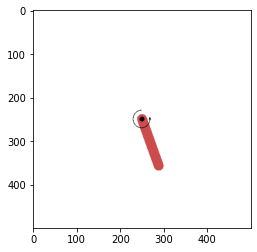

In [1]:
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import TRPO
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make('Pendulum-v0')

model = TRPO(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=25000)
model.save("trpo_pendulum")

del model # remove to demonstrate saving and loading

model = TRPO.load("trpo_pendulum")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())


In [6]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 49kB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 
     |████████████████████████████████| 491kB 38.7MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
#TRPO for CartPole


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
import keras.backend as k
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

class TRPOAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.Actor=self.build_actor_model()
    self.Critic=self.build_critic_model()
    
    self.Critic.summary()
  
  def build_actor_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Actor=Sequential()
    Actor.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(self.action_size,activation='softmax'))
    def trpo_loss(y_true,y_pred):
      entropy=2e-5
      old_log= k.sum(y_true)
      print(old_log)
      pred_log=k.sum(y_pred)
      print(pred_log)
      kl_divergence= k.sum(old_log* k.log(old_log/pred_log))
      prob=1e-2
      loss=-k.mean(kl_divergence + entropy*(-(prob*k.log(prob+1e-10))))
      return loss
    Actor.compile(optimizer=Adam(learning_rate=self.learning_rate),loss=trpo_loss)
    return Actor
  def build_critic_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Critic=Sequential()
    Critic.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(self.action_size,activation='softmax'))
    Critic.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Critic


  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.Critic.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards


  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.Actor.train_on_batch(x,y)
    self.Critic.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.Actor.load_weights(name)
    self.Critic.load_weights(name)
  
  def save_model(self,name):
    self.Actor.save_weights(name)
    
    self.Critic.save_weights(name)
if __name__=="__main__":
  env=gym.make('CartPole-v0')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=TRPOAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      

KeyboardInterrupt: ignored